## New RAG Approach: Grep visual Embeddings from HF Database and compare to a Query Embedding

In [2]:
from caching import load_full_hf_cache

repo_name = "ScaDS-AI/SlideInsight_Cache"
df = load_full_hf_cache(repo_name=repo_name)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
df.head()

,key,zenodo_record_id,zenodo_filename,page_number,text_embedding,visual_embedding,mixed_embedding,extracted_text
0,record10008464_pdf1_slide1,10008464,2023-Moore-N4BI-AHM-Welcome.pdf,1,"[0.8054575, -0.4204579, 0.111390926, 0.2636367...","[0.22024887800216675, 0.6564452648162842, 0.02...","[0.22330284, -0.5643485, 0.32713842, -0.074667...","Welcome to\nBioImage Town!\nJosh Moore, Senior..."
1,record10008464_pdf1_slide2,10008464,2023-Moore-N4BI-AHM-Welcome.pdf,2,"[1.1522328, 0.02467385, 0.23145455, 0.17258961...","[-0.3846272826194763, -0.01668522134423256, -0...","[0.34757608, -0.6562839, 0.5335755, -0.1906935...",Special welcome\nHonored New\nGuests Colleague...
2,record10008464_pdf1_slide3,10008464,2023-Moore-N4BI-AHM-Welcome.pdf,3,"[1.0057557, 0.18344171, 0.03796136, 0.23549518...","[-0.32376205921173096, 0.06897055357694626, 0....","[0.06456853, -0.79703176, 0.871621, -0.8768049...",Value of bioimages\nhttps://ome-model.readthed...
3,record10008464_pdf1_slide4,10008464,2023-Moore-N4BI-AHM-Welcome.pdf,4,"[1.2563236, 0.25261688, 0.0040982994, 0.202414...","[-0.03493745997548103, -0.11242333054542542, 0...","[0.3643795, -0.40593308, 0.97395766, -0.495041...",Value of bioimages\nAll-Hands Meeting · Josh M...
4,record10008464_pdf1_slide5,10008464,2023-Moore-N4BI-AHM-Welcome.pdf,5,"[0.8471789, -0.40933934, 0.85754687, -0.496454...","[-0.6693567037582397, -0.02434205450117588, -0...","[-0.22939722, -0.6752343, 0.57570195, 0.046955...","Image Data Management isn’t always FAIR\n""Clar..."


The visual_embedding was extracted with the "openai/clip-vit-base-patch32" model, so this is used for the query as well

In [4]:
from transformers import CLIPProcessor, CLIPModel
import torch
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [5]:
# Create Query embedding

text_query = "What means the By-Attribution in a License?"

# Tokenize the text 
inputs = clip_processor(text=[text_query], return_tensors="pt", padding=True)

# Get the text embedding from the model
with torch.no_grad():
    query_embedding = clip_model.get_text_features(**inputs)

# Normalize and send to the Device
query_vector = query_embedding / query_embedding.norm(dim=-1, keepdim=True) 
query_vector = query_vector.cpu().numpy()

In [6]:
# Extract the visual embeddings
visual_embeddings = df['visual_embedding'].apply(lambda x: np.array(x))
visual_matrix = np.stack(visual_embeddings.to_list())  # shape: (N, D)

In [7]:
# Compute similarity between the embedding matrix and the query vector
similarities = cosine_similarity(query_vector, visual_matrix) 
similarities = similarities.flatten()  
similarities

array([0.19598577, 0.23083748, 0.20588289, ..., 0.24298333, 0.21256349,
       0.19652608])

## Now all similarities were computed and can add those back to the DataFrame to sort it accordingly to the best results

In [8]:
df['similarity_to_query'] = similarities

In [9]:
# Get the 5 best matches
top_matches = df.sort_values(by='similarity_to_query', ascending=False).head(5)

In [10]:
print(top_matches[['key', 'similarity_to_query']])

                               key  similarity_to_query
1168    record12623730_pdf3_slide4             0.319534
524   record10990107_pdf1_slide112             0.313324
1808  record12623730_pdf14_slide14             0.313284
1167    record12623730_pdf3_slide3             0.313094
556     record11066250_pdf1_slide4             0.312550


# Now we can access the images using the Image Dataset on Huggingface

In [11]:
keys = top_matches['key'].tolist()

In [12]:
from datasets import load_dataset, Image
dataset = load_dataset("ScaDS-AI/Slide_Insight_Images")["train"]  
dataset = dataset.cast_column("image", Image())

In [13]:
df = dataset.to_pandas()

In [14]:
# Filter the rows to obtain the Images with the highest similarity to the Query
filtered_df = df[df["key"].isin(keys)]

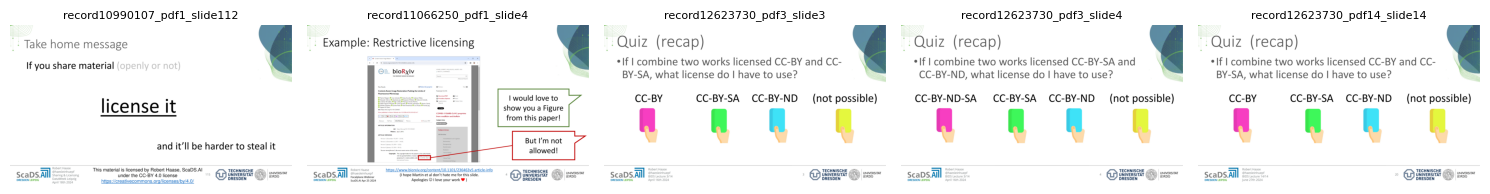

In [22]:
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# Limit to first 5 rows (or use all if <5)
num_images = min(5, len(filtered_df))
fig, axs = plt.subplots(1, num_images, figsize=(15, 4))

for i, (_, row) in enumerate(filtered_df.iloc[:num_images].iterrows()):
    img_bytes = row["image"]["bytes"]
    img = Image.open(BytesIO(img_bytes)).convert("RGB")

    axs[i].imshow(img)
    axs[i].set_title(row["key"], fontsize=8)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

### Now we can convert the Images and send them to the VLM

In [16]:
from PIL import Image
from io import BytesIO
import base64

def encode_image_from_bytes(image_bytes):
    img = Image.open(BytesIO(image_bytes)).convert("RGB")
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    encoded = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{encoded}"

In [17]:
# Prepare list of image payloads
image_query = []

for _, row in filtered_df.iterrows():
    image_bytes = row["image"]["bytes"]
    encoded_image = encode_image_from_bytes(image_bytes)
    
    image_query.append({
        "type": "image_url",
        "image_url": {
            "url": encoded_image
        }
    })

# Add Text Query
image_query.append({
    "type": "text",
    "text": text_query
})

In [21]:
from openai import OpenAI
import os

# access the VLM via the SCADS API
my_api_key = os.getenv('SCADS_KEY')
client = OpenAI(base_url="https://llm.scads.ai/v1",api_key=my_api_key)

for model in client.models.list().data:
    model_name = model.id
    if "Llama-4-Scout" in model_name:
        break

In [23]:
# Send the request to the VLM
response = client.chat.completions.create(
    model=model_name,
    messages=[
        {
            "role": "system",
            "content": "Try to anwser the following question using information from the given images, combined with the knowledge you have. Also try to answer in a short, but precise manner. Don't anwser in more than 10 sentences or bullet points.",
            "role": "user",
            "content": image_query
        }
    ],
    max_tokens=500
)

In [24]:
summary = response.choices[0].message.content
print(summary)

The term "BY" in a Creative Commons (CC) license refers to the requirement that the work must be attributed to its creator. This means that when using or sharing a work licensed under CC-BY, CC-BY-SA, or CC-BY-ND, you must give proper credit to the original author or creator.

In other words, "BY" stands for "attribution," which is a crucial aspect of Creative Commons licenses. They allow users to use, share, and modify works while ensuring that the original creator receives credit for their work.

Here are some examples of how attribution might work:

*   In academic or professional settings, you might include a citation or a reference to the original work.
*   In online platforms, you could provide a link to the original source or include a credit line with the creator's name.
*   In presentations or publications, you might include a footnote or an acknowledgment that references the original work.

By requiring attribution, Creative Commons licenses promote transparency, accountabili